$$\Large{\textbf{Subreddit Classifier}}$$ 

$$_______________________________________________________________________________________________$$


The following code extracts text data from various forums on Reddit.com and trains a classifier to read and predict the subreddit a post belongs to.

This is achieved using various Natural Language Processing techniques; 
 - tokenizing/lemmatizing the data
 - vectorizing each post
 - finding a low-rank approximation to the term-document matrix

 
I make an attempt to balance mathematical formalism and common english in describing this process.




In [3]:
# Chose our list of subreddits to train our classifier on
subreddits = ['biology','physics','chemistry','mathematics',\
              'machinelearning','cscareerquestions','datascience',\
              'standup']

# Reddit's Python API Wrapper
import praw

# Load in data
reddit = praw.Reddit(client_id='adIKBNrVd9Rzdw',client_secret='0zwY4fRfqwqHI2q4gx2gxGHa5zI',user_agent = 'Reddit Scraper')    


$$\text{We create a list of character strings corresponding to each post, and label them by subreddit}$$

In [4]:
import pandas as pd
import numpy as np
import re

# Instantiate lists
all_posts , sub_labels = list(), list()

# Loop over list of subreddits
for i, sub in enumerate(subreddits):
    
    # Get text from 25000 latest posts
    subreddit_data = reddit.subreddit( sub ).new( limit = 25000 )
    
    # Limit to those at least 80 alphabetic characters
    posts = [post.selftext for post in subreddit_data if len(re.sub('\W|\d', '', post.selftext)) >= 80]

    # Add posts/labels to respective lists
    all_posts += posts
    sub_labels += [i] * len(posts) 
    
    # Print after success
    print("number of posts from {}: ".format(sub),len(posts)) 


number of posts from biology:  512
number of posts from physics:  222
number of posts from chemistry:  550
number of posts from mathematics:  820
number of posts from machinelearning:  884
number of posts from cscareerquestions:  975
number of posts from datascience:  745
number of posts from standup:  742


$$\text{Visually analyze how the posts are distributed:}$$

In [3]:
# Pyplot for data visualization (import in a seperate cell from plot to display)
import matplotlib.pyplot as plt

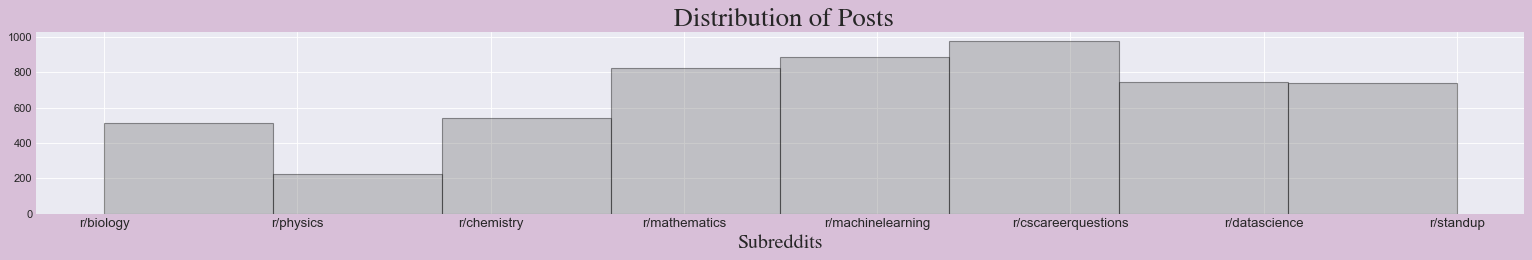

In [4]:
# Select desired style for our plot
plt.style.use('seaborn-darkgrid')

# Set figure specifications
plt.figure(figsize = (3*len(subreddits),3), dpi=80, facecolor='thistle')
# Set Title
plt.title(" Distribution of Posts", size = 24, style = 'italic',  fontname='Times')
# Set xlabel
plt.xlabel("Subreddits", size=18,  fontname='Times')
# Set tick labels
plt.xticks(range(len(subreddits)), labels=["r/{}".format(sub) for sub in subreddits], size=12) 
# Plot the histogram
plt.hist(np.array(sub_labels), bins = len(subreddits),color='grey', alpha = 0.4, edgecolor='k') 

plt.show() 

$$\text{Defining custom preprocessing functions}$$

We clean our text data in the following ways:
- Break the post into individual words, removing not alphabetic characters and URL-like strings
- Lemmatize the words so we weight the same concepts equally ("playing" = "plays" = "played")
- Remove 1-letter words and 'stop words' that do not convey meaning in the text ("i", "a", "be", "in")

In [5]:
# Natural Language Tool Kit and several preprocessing methods
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


# Remove all non alphabetic characters, or URL-like patterns
def my_preprocessor(doc):
    return re.sub('\W|\d|http\S+|www\S+',' ',doc)


# Break our post into tokens then lemmatize
def my_tokenizer(text):
    tokens = [word.lower() for word in nltk.word_tokenize(text) \
              if word not in stopwords.words('english') and len(word)>1]
    lemmas = [WordNetLemmatizer().lemmatize(token) for token in tokens]
    return lemmas


# Comparing raw text data from reddit post to list of tokens
print("BEFORE: \n{} ...".format(re.sub('\n','  ',all_posts[0])),\
      "\n\nAFTER: \n",my_tokenizer(my_preprocessor(all_posts[0])))

BEFORE: 
For example a yearly counter of how many of X animals have been born starting with a specific number. ... 

AFTER: 
 ['for', 'example', 'yearly', 'counter', 'many', 'animal', 'born', 'starting', 'specific', 'number']


$$\Large{\text{Vectorizing the text data}}$$

Now that each post is a list of meaningful words, the data can be represented by a term-document matrix. 

Let $\mathbf{v_i}$ be the i'th document in our corpus, and $\mathbf{w_j}$ be the j'th word to appear in our text data.

We can then construct a matrix $\mathbf{X}$, where element $x_{i,j}$ corresponds to the frequency of term $i$ in submission $j$. 

$$\mathbf{X} = 
\begin{bmatrix}
x_{1,1} & \cdots &
x_{1,n} \\
\vdots & \ddots & \vdots \\
x_{m,1} & \cdots &
x_{m,n}
\end{bmatrix}$$


The words are weighted using a "term-frequency, inverse-document-frequency" scale. 

This ensures that each document's words positively correlate to the frequency of occurance in the document, but inversely correlates to how frequently the word appears in the entire corpus.

In [6]:
# Use Tfidf to vectorize posts
from sklearn.feature_extraction.text import TfidfVectorizer

# Use our predefined functions to clean the data
vectorizer = TfidfVectorizer(preprocessor = my_preprocessor, \
                             tokenizer = my_tokenizer, \
                             min_df = 1)

# Our term-document matrix
X = vectorizer.fit_transform(all_posts)


In [7]:
X

<5443x19572 sparse matrix of type '<class 'numpy.float64'>'
	with 266299 stored elements in Compressed Sparse Row format>

Above, we see our matrix $\mathbf{X}$ is huge and sparsely populated, in order to better cluster our posts we seek to find a low rank approximation.


In [7]:
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD

tsvd = TruncatedSVD(n_components = 100, n_iter = 10)
X_reduced = tsvd.fit_transform(csr_matrix(X).toarray())


Splitting the data into training and validation sets:

In [11]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
xtr, xte, ytr, yte = train_test_split(X_reduced, np.array(sub_labels), test_size = .2, random_state = 1)


$$\text{Fitting a Logistic Regression Classifier to the reduced data}$$

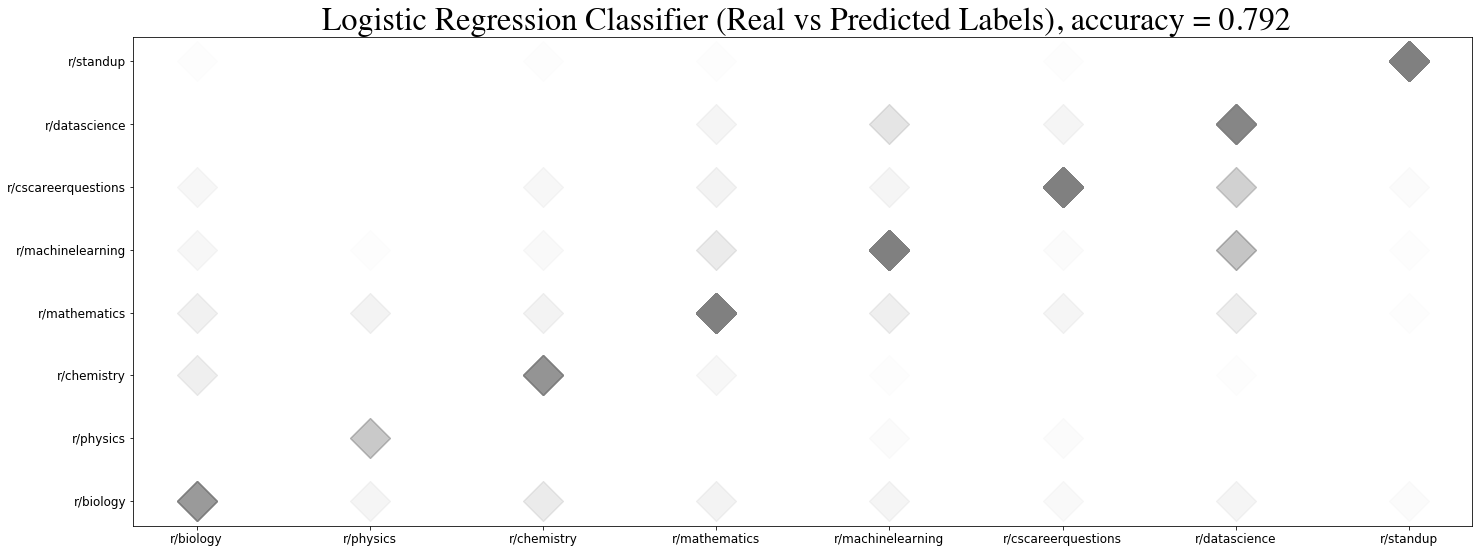

In [21]:
from sklearn.linear_model import LogisticRegressionCV

# Specify our models attributes
lrcv = LogisticRegressionCV(max_iter = 200,\
                            multi_class = 'multinomial',\
                            cv = 5,\
                            n_jobs = -1).fit(xtr,ytr) 
# Save predicted classes
predict = lrcv.predict(xte)

# Measure the accuracy of our model
from sklearn.metrics import accuracy_score
acc = round(accuracy_score(predict, yte), 3) 

# Plot the predictions as a function of true label
plt.figure(figsize = (3*len(subreddits), len(subreddits)+1))
plt.title(" Logistic Regression Classifier (Real vs Predicted Labels), accuracy = {}".format(acc), fontsize='32', fontname='Times')
plt.scatter(yte, predict, alpha = 0.01, s = 800, marker = 'D', c='grey')
plt.xticks(range(len(subreddits)), labels=["r/{}".format(sub) for sub in subreddits], size=12) 
plt.yticks(range(len(subreddits)), labels=["r/{}".format(sub) for sub in subreddits], size=12) 

plt.show()

Above, we see that our classifier is more accurate with outlying subreddits (r/standup is almost never guessed, unless it is the true label) than with those which overlap significantly in semantic content (the machinelearning and datascience forums specifically)